# NLP Classifier questions

The aim of this is a binary classifier. Given an unseen set of statements and correctly decipher if they are movie questions or stackoverflow posts

## Libraries

### Colaboratory Specific Code

This mounts your Google Drive folder so you can access it from Colaboratory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We also want to change the working directory so that the file references work. Here I've places the files for this class inside a folder called 'class_1' that itself is inside a folder called 'NLP_class'.

In [2]:
%cd drive/My\ Drive/NLP_class/0719_question
!ls

/content/drive/My Drive/NLP_class/0719_question
 dialogues.tsv			   Solution_hw_stackoverflow.ipynb
 July_2019_NLP_Questions.ipynb	   tagged_posts.tsv
'NLP Additional Exercise.docx'	   tfidf_vectorizer.pkl
'NLP class.ipynb'		   utils.py
 Question_hw_stackoverflow.ipynb


In [3]:
!pip install scikit-plot

### Dependencies

In [4]:
import pandas as pd
from sklearn.utils import shuffle
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

# Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

np.random.seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(n_splits=5, random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    plot_confusion_matrix(y, preds)

## Pre-process the data

This code cleans the text

In [0]:
# There is a problem with this codes as it is possible for all words to be removed leaving a null value
# This is solved in line 25 with the if statement

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE, "", text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " " + text + " "
    for sw in STOPWORDS:
        text = text.replace(" "+sw+" ", " ") # delete stopwords from text
    text = re.sub('[ ][ ]+', " ", text)

    #     print("text:", text)
#     print(len(text))
    
    if len(text) > 1: # only run if there are words present
      if text[0] == ' ':
          text = text[1:]
      if text[-1] == ' ':
          text = text[:-1]
        
    return text

### Inspect Data
Let's see what the data looks like

In [0]:
dialogues = pd.read_csv('dialogues.tsv', sep='\t')
tagged = pd.read_csv('tagged_posts.tsv', sep='\t')

In [8]:
dialogues.head(2)

,text,tag
0,Okay -- you're gonna need to learn how to lie.,dialogue
1,I'm kidding. You know how sometimes you just ...,dialogue


In [9]:
tagged.head(2)

,post_id,title,tag
0,9,Calculate age in C#,c#
1,16,Filling a DataSet or DataTable from a LINQ que...,c#


# Movie or StackOverflow?

### Create base dataset

Now we can drop the 'tag' columns of both and assign new labels. 

We set a movie question to label 0 and a stack overflow post to label 1

We also need to drop the 'post_id' column of the stack overflow data and rename 'title' to 'text'

In [10]:
movie = dialogues.drop(columns=['tag'])
movie['label'] = int(0)
movie.head(2)

,text,label
0,Okay -- you're gonna need to learn how to lie.,0
1,I'm kidding. You know how sometimes you just ...,0


In [11]:
stack = tagged.drop(columns=['post_id','tag'])
stack['label'] = int(1)
stack = stack.rename(columns={"title": "text"})
stack.head(2)

,text,label
0,Calculate age in C#,1
1,Filling a DataSet or DataTable from a LINQ que...,1


We now combine the two different data sets into one single data set.

In [12]:
data = movie.append(stack, ignore_index=True)
data.head()

,text,label
0,Okay -- you're gonna need to learn how to lie.,0
1,I'm kidding. You know how sometimes you just ...,0
2,Like my fear of wearing pastels?,0
3,I figured you'd get to the good stuff eventually.,0
4,Thank God! If I had to hear one more story ab...,0


### Clean the text

In [13]:
data.shape

(615477, 2)

Here we can see that certain lines are entirely made up of stopwords and symbols. We need to account for this.

In [14]:
print("This line: ", data.loc[82457, 'text'])
print("\nBecomes: ", text_prepare(data.loc[82457, 'text']))

This line:  Do you have to do that?

Becomes:  do


Now we run the cleaning function on the whole database.

In [15]:
%time cleaned_text = [text_prepare(x) for x in data['text']]

CPU times: user 46 s, sys: 122 ms, total: 46.1 s
Wall time: 46.1 s


In [16]:
clean_text = pd.DataFrame({'clean_data': cleaned_text})
clean_text.head()

,clean_data
0,okay youre gonna need learn lie
1,im kidding know sometimes become persona dont ...
2,like fear wearing pastels
3,figured youd get good stuff eventually
4,thank god hear one story coiffure


In [17]:
clean = pd.concat([clean_text, data], axis = 1, ignore_index=True)
clean = shuffle(clean)
clean.head()

,0,1,2
378098,syntax error insert statement c# oledb,Syntax error in INSERT INTO statement in c# ol...,1
274212,applying methods object private variables java...,applying methods to object and private variabl...,1
527013,xampp openssl errors calling openssl_pkey_new,xampp openssl errors when calling openssl_pkey...,1
25072,let buyer beware,Let the buyer beware.,0
491370,read write locking confusion,Read/Write locking confusion,1


In [18]:
clean = clean.drop(columns=[1])
clean.head(20)

,0,2
378098,syntax error insert statement c# oledb,1
274212,applying methods object private variables java...,1
527013,xampp openssl errors calling openssl_pkey_new,1
25072,let buyer beware,0
491370,read write locking confusion,1
176289,im alright,0
323152,get last segment regular expression,1
588685,wcf service completely locked,1
102626,ask theres nothing new coke,0
380088,complex example project java desktopstyle gui,1


Check that there are only 2 labels (binary) and see the amount of each.

In [19]:
unique_labels = clean.groupby(2).nunique()
unique_labels.head()

,0,2
2,,
0,206954,1
1,394527,1


### Train Test Validation Split

In [20]:
clean_data = clean[0]
clean_data.head()

378098               syntax error insert statement c# oledb
274212    applying methods object private variables java...
527013        xampp openssl errors calling openssl_pkey_new
25072                                      let buyer beware
491370                         read write locking confusion
Name: 0, dtype: object

In [21]:
clean_labels = clean[2]
clean_labels.head()

378098    1
274212    1
527013    1
25072     0
491370    1
Name: 2, dtype: int64

First we split off the validation set as 20% of the overall data set.

In [0]:
df_data, X_val, df_labels, y_val = train_test_split(
    clean_data, clean_labels, test_size=0.2, random_state=42, shuffle=False)

Then we split the remaining into training and test data.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.25,
                                                        random_state=42,
                                                        shuffle=False)

The end result is 60% training data, 20% test data and 20% validation data

In [24]:
print("Shape of X_train", X_train.shape)
print("Shape of y_train", X_train.shape)
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)
print("Shape of X_val", X_val.shape)
print("Shape of y_val", y_val.shape)

Shape of X_train (369285,)
Shape of y_train (369285,)
Shape of X_test (123096,)
Shape of y_test (123096,)
Shape of X_val (123096,)
Shape of y_val (123096,)


### Apply TF-IDF Weighting

We first need to learn the words for the dictionary from our training data.

In [25]:
vectorizer = TfidfVectorizer(norm=u'l1', token_pattern='(\S+)', min_df=5, max_df=0.9, ngram_range=(1,2))

%time vectorizer.fit_transform(X_train)
# print(vectorizer.get_feature_names(10))

CPU times: user 11.7 s, sys: 259 ms, total: 12 s
Wall time: 12 s


<369285x65391 sparse matrix of type '<class 'numpy.float64'>'
	with 2693650 stored elements in Compressed Sparse Row format>

Apply this learned TF-IDF transform to our different dataframes

In [26]:
%time train_tf = vectorizer.transform(X_train)
# train_tf = csr_matrix.mean(train_tf, axis=0)

%time test_tf = vectorizer.transform(X_test)
# test_tf = csr_matrix.mean(test_tf, axis=0)

%time val_tf = vectorizer.transform(X_val)
# val_tf = csr_matrix.mean(val_tf, axis=0)


CPU times: user 5.99 s, sys: 5.82 ms, total: 5.99 s
Wall time: 5.99 s
CPU times: user 1.94 s, sys: 4.95 ms, total: 1.95 s
Wall time: 1.95 s
CPU times: user 1.96 s, sys: 4.16 ms, total: 1.97 s
Wall time: 1.97 s


We can see that the different dataframes have been transformed intt Compressed Sparse Row format data. This is very important as sparsity has a big impact on accuracy.

In [27]:
print("Shape of train_tf", train_tf.shape)

print("Shape of test_tf", test_tf.shape)

print("Shape of val_tf", val_tf.shape)

Shape of train_tf (369285, 65391)
Shape of test_tf (123096, 65391)
Shape of val_tf (123096, 65391)


## Classify CSR

First we will attempt to classify the full CSR dataset

### Naive Bayes
Interestingly this crashes and causes the runtime to reset as the dimensionality is too high.

In [0]:
# nb = GaussianNB()
# nb.fit(train_tf.todense(), y_train.astype(int))

In [0]:
# nb_score_test = nb.score(test_tf.todense(), y_test.astype(int))
# nb_score_test

### Linear Regression

In [30]:
linr = linear_model.LinearRegression(n_jobs = -1)
%time linr.fit(train_tf, y_train.astype(int))

CPU times: user 1min 26s, sys: 54.7 s, total: 2min 21s
Wall time: 1min 11s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [31]:
%time linr_score_test = linr.score(test_tf, y_test.astype(int))
print(linr_score_test*100)

CPU times: user 14.1 ms, sys: 7.03 ms, total: 21.1 ms
Wall time: 11.6 ms
92.57725130996111


We don't have a confusion matrix for the LR as it returns continuous results not discrete ones

### Logistic Regression

In [32]:
lr = linear_model.LogisticRegression(C=10.0, penalty='l2', solver = 'newton-cg', n_jobs=-1)
%time lr.fit(train_tf, y_train)

CPU times: user 63 ms, sys: 98 ms, total: 161 ms
Wall time: 11 s


LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
%time lr_score_test = lr.score(test_tf, y_test.astype(int))
print(lr_score_test*100)

CPU times: user 20.1 ms, sys: 1.02 ms, total: 21.1 ms
Wall time: 22.7 ms
98.85130304802756


We can better understand the accuracy by looking at a confusion matrix




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s remaining:    0.0s


Log loss: 0.07100661462437051
Accuracy: 0.9844349125885488


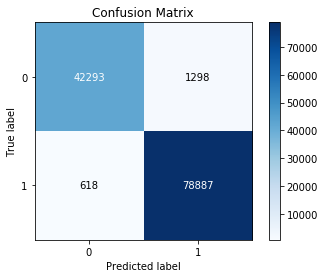

In [34]:
evaluate_features(test_tf, y_test, lr)

### Support Vector Machine
The high dimensionality means that this takes a ridiculous amount of time to run.

In [0]:
# clf = svm.SVC(kernel='linear', C=1, random_state=42)
# %time clf.fit(train_tf, y_train.astype(int))

In [0]:
# %time clf_score = clf.score(test_tf, y_test.astype(int))
# print("SVM accuracy on test:\t %f" % clf_score)

### Random Forest
The high dimensionality means that this takes a ridiculous amount of time to run.

In [37]:
rf = RandomForestClassifier(criterion='gini', max_depth=5, 
                               min_samples_leaf=5, min_samples_split=2, 
                               n_estimators = 220, oob_score=True, 
                               max_features=0.5, n_jobs = -1, random_state=42)

%time rf.fit(train_tf, y_train.astype(int))

CPU times: user 7min 47s, sys: 387 ms, total: 7min 47s
Wall time: 3min 59s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=220,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [38]:
%time rf_score = rf.score(test_tf, y_test.astype(int))
print("RF accuracy on test:\t %f" % rf_score)

CPU times: user 3.2 s, sys: 53.8 ms, total: 3.25 s
Wall time: 1.76 s
RF accuracy on test:	 0.753022


We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 35.3min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 35.3min remaining:    0.0s


Log loss: 0.5385992487192965
Accuracy: 0.7524371222460519


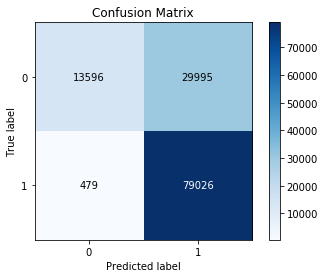

In [39]:
evaluate_features(test_tf, y_test, rf)

We could use a gridsearch to find optimal paramters for a classifier

In [0]:
# rf_grid = RandomForestClassifier(random_state=42)

# param_grid = { 
#     'n_estimators': [100, 120, 140, 160, 180, 200, 220, 240, 260],
#     'min_samples_leaf': [3, 5, 7],
#     'min_samples_split': [2, 3, 4, 5, 6],
#     'max_depth' : [5, 10, 15, 20, 25, 30, 35, 40, 45],
#     'criterion' :['gini', 'entropy']
# }


# CV_rf = GridSearchCV(estimator=rf_grid, param_grid=param_grid, cv= 5, n_jobs = -1, 
#                      verbose = 2)
# CV_rf.fit(train_tf, y_train.astype(int))
# CV_rf.best_params_

## Scores on CSR Validation Set

In [0]:
# nb_score_val = nb.score(val_tf.todense(), y_val.astype(int))
# nb_score_val

In [42]:
linr_score_val = linr.score(val_tf, y_val.astype(int))
linr_score_val

0.9276993118772889

In [43]:
lr_score_val = lr.score(val_tf, y_val.astype(int))
lr_score_val

0.9890898160785079

In [0]:
# clf_score_val = clf.score(X_val, y_val.astype(int))
# clf_score_val

In [45]:
rf_score_val = rf.score(val_tf, y_val.astype(int))
rf_score_val

0.7535581984792357

## Classify Reduced
We will now reduce the dimensionality of the dataset and rety classification.

### Reduce Dimensions using SVD

In [0]:
NUM_DIMEN = 50
svd = TruncatedSVD(n_components=NUM_DIMEN)

In [47]:
%time train_sv = svd.fit_transform(train_tf)
var = svd.explained_variance_.sum() * 100
print("Training data variance with %d SVD components is %f" % (NUM_DIMEN, var))

CPU times: user 17.9 s, sys: 2.61 s, total: 20.5 s
Wall time: 15.2 s
Training data variance with 50 SVD components is 1.626472


In [48]:
%time test_sv = svd.fit_transform(test_tf)
%time val_sv = svd.fit_transform(val_tf)

CPU times: user 6.49 s, sys: 1.61 s, total: 8.1 s
Wall time: 5.01 s
CPU times: user 6.69 s, sys: 1.59 s, total: 8.27 s
Wall time: 5.1 s


In [49]:
print("Shape of train_sv", train_sv.shape)

print("Shape of test_sv", test_sv.shape)

print("Shape of val_sv", val_sv.shape)

Shape of train_sv (369285, 50)
Shape of test_sv (123096, 50)
Shape of val_sv (123096, 50)


### Naive Bayes
With the reduced dimensionality we can use a Naive Bayes classifier

In [50]:
nb_sv = GaussianNB()
%time nb_sv.fit(train_sv, y_train.astype(int))

CPU times: user 387 ms, sys: 7.19 ms, total: 394 ms
Wall time: 395 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [51]:
%time nb_score_test_sv = nb_sv.score(test_sv, y_test.astype(int))
nb_score_test_sv*100

CPU times: user 119 ms, sys: 5 ms, total: 124 ms
Wall time: 123 ms


51.119451485019816

We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Log loss: 1.9731315874176123
Accuracy: 0.8159160330148827


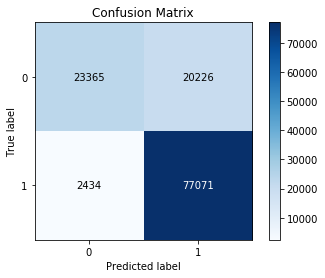

In [52]:
evaluate_features(test_sv, y_test, nb_sv)

### Linear Regression

In [53]:
linr_sv = linear_model.LinearRegression(n_jobs = -1)
%time linr_sv.fit(train_sv, y_train.astype(int))

CPU times: user 2.21 s, sys: 221 ms, total: 2.43 s
Wall time: 1.51 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [54]:
%time linr_score_test_sv = linr_sv.score(test_sv, y_test.astype(int))
linr_score_test_sv*100

CPU times: user 27.2 ms, sys: 5.93 ms, total: 33.2 ms
Wall time: 21.8 ms


-91.39547821604575

We don't have a confusion matrix for the LR as it returns continuous results not discrete ones

### Logistic Regression

In [55]:
lr_sv = linear_model.LogisticRegression(C=1.0, penalty='l2', solver = 'newton-cg', n_jobs=-1)
%time lr_sv.fit(train_sv, y_train)

CPU times: user 114 ms, sys: 135 ms, total: 249 ms
Wall time: 17.8 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
%time lr_score_test_sv = lr_sv.score(test_sv, y_test.astype(int))
lr_score_test_sv*100

CPU times: user 36.6 ms, sys: 5.85 ms, total: 42.5 ms
Wall time: 30.6 ms


24.341976993565996

We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.7s finished


Log loss: 0.2536325937205218
Accuracy: 0.9216465197894327


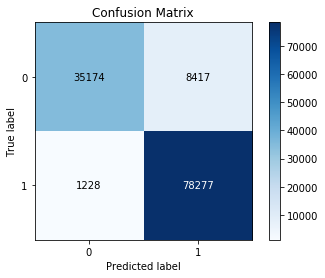

In [57]:
evaluate_features(test_sv, y_test, lr_sv)

### Support Vector Machine
Even at low dimension this takes a lot of time to run.

In [0]:
# clf_sv = svm.SVC(kernel='linear', C=1, random_state=42)
# %time clf_sv.fit(train_sv, y_train.astype(int))

In [0]:
# %time clf_score_sv = clf_sv.score(test_sv, y_test.astype(int))
# print("SVM accuracy on test:\t %f" % clf_score_sv)

### Random Forest

In [0]:
rf_sv = RandomForestClassifier(criterion='gini', max_depth=5, 
                               min_samples_leaf=5, min_samples_split=2, 
                               n_estimators = 220, oob_score=True, 
                               max_features=0.5, n_jobs = -1, random_state=42)

%time rf_sv.fit(train_sv, y_train.astype(int))

In [0]:
%time rf_score_sv = rf_sv.score(test_sv, y_test.astype(int))
print("RF accuracy on test:\t %f" % rf_score_sv)

We can better understand the accuracy by looking at a confusion matrix

In [0]:
evaluate_features(test_sv, y_test, rf_sv)

# Which Programming Language?

### Clean the Text and Assign Labels

First we load in the StackOverflow dataset and drop the unused post_id column

In [0]:
tagged.head()

In [0]:
stackover = tagged.drop(columns=['post_id'])
stackover.head()

In [0]:
relevant_stack = [text_prepare(x) for x in stackover['title']]
clean_titles = pd.DataFrame({'clean_data': relevant_stack})
clean_titles.head()

In [0]:
clean_stack = pd.concat([clean_titles, stackover], axis = 1, ignore_index=True)
clean_stack = shuffle(clean_stack)
clean_stack.head()

In [0]:
clean_stack = clean_stack.drop(columns=[1])
clean_stack.head(15)

Check how many unique labels we have

In [0]:
unique_languages = clean_stack.groupby(2).nunique()
unique_languages.head(15)

Now we convert these categorical labels into numericals ones

In [0]:
clean_stack[2] = clean_stack[2].astype('category')
clean_stack["label"] = clean_stack[2].cat.codes
clean_stack.head(10)

In [0]:
clean_stack = clean_stack.drop(columns=[2])
clean_stack.head()

### Train Test Validation Split

In [0]:
stack_data = clean_stack[0]
stack_data.head()

In [0]:
stack_labels = clean_stack['label']
stack_labels.head()

First we split off the validation set as 20% of the overall data set.

In [0]:
df_data, X_val, df_labels, y_val = train_test_split(
    stack_data, stack_labels, test_size=0.2, random_state=42, shuffle=False)

Then we split the remaining into training and test data.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.25,
                                                        random_state=42,
                                                        shuffle=False)

The end result is 60% training data, 20% test data and 20% validation data

In [0]:
print("Shape of X_train", X_train.shape)
print("Shape of y_train", X_train.shape)
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)
print("Shape of X_val", X_val.shape)
print("Shape of y_val", y_val.shape)

### Apply TF-IDF Weighting

We first need to learn the words for the dictionary from our training data.

In [0]:
vectorizer = TfidfVectorizer(norm=u'l1', token_pattern='(\S+)', min_df=5, max_df=0.9, ngram_range=(1,2))

%time vectorizer.fit_transform(X_train)
# print(vectorizer.get_feature_names(10))

Apply this learned TF-IDF transform to our different dataframes

In [0]:
%time train_tf = vectorizer.transform(X_train)
# train_tf = csr_matrix.mean(train_tf, axis=0)

%time test_tf = vectorizer.transform(X_test)
# test_tf = csr_matrix.mean(test_tf, axis=0)

%time val_tf = vectorizer.transform(X_val)
# val_tf = csr_matrix.mean(val_tf, axis=0)


We can see that the different dataframes have been transformed intt Compressed Sparse Row format data. This is very important as sparsity has a big impact on accuracy.

In [0]:
print("Shape of train_tf", train_tf.shape)

print("Shape of test_tf", test_tf.shape)

print("Shape of val_tf", val_tf.shape)

## Classify CSR

First we will attempt to classify the full CSR dataset

### Naive Bayes
Interestingly this crashes and causes the runtime to reset as the dimensionality is too high.

In [0]:
# nb = GaussianNB()
# nb.fit(train_tf.todense(), y_train.astype(int))

In [0]:
# nb_score_test = nb.score(test_tf.todense(), y_test.astype(int))
# nb_score_test

### Linear Regression

In [0]:
linr = linear_model.LinearRegression(n_jobs = -1)
%time linr.fit(train_tf, y_train.astype(int))

In [0]:
%time linr_score_test = linr.score(test_tf, y_test.astype(int))
linr_score_test*100

### Logistic Regression
This is automatically a mult-class classifier. Effectively a One vs Rest LR

In [0]:
# lr = linear_model.LogisticRegression(C=1.0, penalty='l2', solver = 'saga', n_jobs=-1)
lr = linear_model.LogisticRegression(solver='newton-cg',C=5, penalty='l2',n_jobs=-1)

%time lr.fit(train_tf, y_train)

In [0]:
%time lr_score_test = lr.score(test_tf, y_test.astype(int))
lr_score_test*100

### Support Vector Machine
The high dimensionality means that this takes a ridiculous amount of time to run.

In [0]:
# clf = svm.SVC(kernel='linear', C=1, random_state=42)
# %time clf.fit(train_tf, y_train.astype(int))

In [0]:
# %time clf_score = clf.score(test_tf, y_test.astype(int))
# print("SVM accuracy on test:\t %f" % clf_score)

### Random Forest
The high dimensionality means that this takes a ridiculous amount of time to run.

In [0]:
rf = RandomForestClassifier(criterion='gini', max_depth=5, 
                               min_samples_leaf=5, min_samples_split=2, 
                               n_estimators = 220, oob_score=True, 
                               max_features=0.5, n_jobs = -1, random_state=42)

%time rf.fit(train_tf, y_train.astype(int))

In [0]:
%time rf_score = rf.score(test_tf, y_test.astype(int))
print("RF accuracy on test:\t %f" % rf_score)

## Scores on CSR Validation Set

In [0]:
# nb_score_val = nb.score(val_tf.todense(), y_val.astype(int))
# nb_score_val

In [0]:
linr_score_val = linr.score(val_tf, y_val.astype(int))
linr_score_val

In [0]:
lr_score_val = lr.score(val_tf, y_val.astype(int))
lr_score_val

In [0]:
# clf_score_val = clf.score(X_val, y_val.astype(int))
# clf_score_val

In [0]:
rf_score_val = rf.score(val_tf, y_val.astype(int))
rf_score_val

## Classify Reduced
We will now reduce the dimensionality of the dataset and rety classification.

### Reduce Dimensions using SVD

In [0]:
NUM_DIMEN = 50
svd = TruncatedSVD(n_components=NUM_DIMEN)

In [0]:
%time train_sv = svd.fit_transform(train_tf)
var = svd.explained_variance_.sum() * 100
print("Training data variance with %d SVD components is %f" % (NUM_DIMEN, var))

In [0]:
%time test_sv = svd.fit_transform(test_tf)
%time val_sv = svd.fit_transform(val_tf)

In [0]:
print("Shape of train_sv", train_sv.shape)

print("Shape of test_sv", test_sv.shape)

print("Shape of val_sv", val_sv.shape)

### Naive Bayes
With the reduced dimensionality we can use a Naive Bayes classifier

In [0]:
nb_sv = GaussianNB()
%time nb_sv.fit(train_sv, y_train.astype(int))

In [0]:
%time nb_score_test_sv = nb_sv.score(test_sv, y_test.astype(int))
nb_score_test_sv*100

We can better understand the accuracy by looking at a confusion matrix

In [0]:
evaluate_features(test_sv, y_test, nb_sv)

### Linear Regression

In [0]:
linr_sv = linear_model.LinearRegression(n_jobs = -1)
%time linr_sv.fit(train_sv, y_train.astype(int))

In [0]:
%time linr_score_test_sv = linr_sv.score(test_sv, y_test.astype(int))
linr_score_test_sv*100

We don't have a confusion matrix for the LR as it returns continuous results not discrete ones

### Logistic Regression

In [0]:
lr_sv = linear_model.LogisticRegression(C=5.0, penalty='l2', solver = 'newton-cg', n_jobs=-1)
%time lr_sv.fit(train_sv, y_train)

In [0]:
%time lr_score_test_sv = lr_sv.score(test_sv, y_test.astype(int))
lr_score_test_sv*100

We can better understand the accuracy by looking at a confusion matrix

In [0]:
evaluate_features(test_sv, y_test, lr_sv)

### Support Vector Machine
Even at low dimension this takes a lot of time to run.

In [0]:
# clf_sv = svm.SVC(kernel='linear', C=1, random_state=42)
# %time clf_sv.fit(train_sv, y_train.astype(int))

In [0]:
# %time clf_score_sv = clf_sv.score(test_sv, y_test.astype(int))
# print("SVM accuracy on test:\t %f" % clf_score_sv)

### Random Forest

In [0]:
rf_sv = RandomForestClassifier(criterion='gini', max_depth=5, 
                               min_samples_leaf=5, min_samples_split=2, 
                               n_estimators = 220, oob_score=True, 
                               max_features=0.5, n_jobs = -1, random_state=42)

%time rf_sv.fit(train_sv, y_train.astype(int))

In [0]:
%time rf_score_sv = rf_sv.score(test_sv, y_test.astype(int))
print("RF accuracy on test:\t %f" % rf_score_sv)

We can better understand the accuracy by looking at a confusion matrix

In [0]:
evaluate_features(test_sv, y_test, rf_sv)